## Utilizzando un modello LSTM, alleniamo un modello per generare del testo simile ad 'Alice nel Paese delle Meraviglie'
- Il dataset e le librerie da installare per svolgere questa Esercitazione ti sono fornite nelle prime celle di questo notebook
- Leggi il testo e definisci una funzione per estrarre dei chunk da esso
- Definisci una classe che contiene tutto il necessario per costruire un modello generativo ricorrente di tipo LSTM, che prende in input una sequenza di caratteri e restituisce in output una sequenza di caratteri generati (utilizza il modulo torch.nn.LSTM per definire il componente di LSTM della architettura)
- Definisci una funzione per convertire in tensore la sequenza di caratteri
- Definisci una funzione per creare variabile di input e target da utilizzare per allenare il modello
- Lancia il training del modello (dopo aver definito delle funzioni per farlo e per fare l'evaluation)
- Controlla la training loss e prova a valutare (qualitativamente) la generazione di testo ottenuta al termine del training del modello



<font color='red'>Va BENISSIMO fare copia-incolla dai notebook precedenti: <br>
&nbsp;&nbsp;&nbsp;&nbsp; → non devi imparare cose a memoria, devi capire come funzionano e sapere dove copiare, cosa modifiare e come! <br>
 Riuscirai a generare un testo analogo ad 'Alice nel Paese delle Meraviglie'?
</font>

In [ ]:
!pip install unidecode

In [ ]:
!wget 'https://gist.githubusercontent.com/phillipj/4944029/raw/75ba2243dd5ec2875f629bf5d79f6c1e4b5a8b46/alice_in_wonderland.txt'

--2024-07-06 13:57:22--  https://gist.githubusercontent.com/phillipj/4944029/raw/75ba2243dd5ec2875f629bf5d79f6c1e4b5a8b46/alice_in_wonderland.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148574 (145K) [text/plain]
Saving to: ‘alice_in_wonderland.txt’

alice_in_wonderland 100%[===================>] 145.09K  --.-KB/s    in 0.02s   

2024-07-06 13:57:22 (8.15 MB/s) - ‘alice_in_wonderland.txt’ saved [148574/148574]



In [ ]:
import re
import unidecode
import string
import random

import torch
import torch.nn as nn
from torch.autograd import Variable


In [ ]:
all_characters = string.printable
n_characters = len(all_characters)

text = unidecode.unidecode(open("/content/alice_in_wonderland.txt", 'rb').read().decode(encoding='utf-8'))
text_len = len(text)
print('text_len =', text_len)


text_len = 148574


In [ ]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, text_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(text))


anything near the right size,
that it felt quite strange at first; but she got used to it in a
few minutes, and began talking to herself, as usual.  `Come,
there's half my plan done now!  How puzzling 


In [ ]:
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

72 unique characters


In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.encoder = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.lstm(input, hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return (Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
                Variable(torch.zeros(self.n_layers, 1, self.hidden_size)))


In [ ]:
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))


tensor([10, 11, 12, 39, 40, 41])


In [ ]:
def random_training_set(text):
    chunk = random_chunk(text)
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target


In [ ]:
def train(inp, target, device="cpu"):
    hidden = decoder.init_hidden()
    hidden = tuple([h.to(device) for h in hidden])
    decoder.zero_grad()
    loss = 0
    haiku_len = len(inp)
    for c in range(haiku_len):
        hidden = tuple([h.data for h in hidden])
        output, hidden = decoder(inp[c].to(device), hidden)
        loss += criterion(output, target[c].to(device).view(-1))

    loss.backward()
    decoder_optimizer.step()

    return loss.item() / haiku_len


In [ ]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8, device="cpu"):
    hidden = decoder.init_hidden()
    hidden = tuple([h.to(device) for h in hidden])
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        hidden = tuple([h.data for h in hidden])
        _, hidden = decoder(prime_input[p].to(device), hidden)
    inp = prime_input[-1]

    for p in range(predict_len):
        hidden = tuple([h.data for h in hidden])
        output, hidden = decoder(inp.to(device), hidden)

        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]

        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted


In [ ]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 256
n_layers = 3
lr = 0.0005

decoder = LSTM(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda:0")
decoder.to(device)

all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    inp, target = random_training_set(text)
    loss = train(inp, target, device=device)
    loss_avg += loss

    if epoch % print_every == 0:
        print('[(%d %d%%) %.4f]' % (epoch, epoch / n_epochs * 100, loss))
        print(evaluate('Wh', 100, device=device), '\n', )

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0


[(100 5%) 3.0464]
Whnhe la s !awt ewahtt awe n aidul use.;  nst ae eaq gittath ddaen y
  tme ed ten oho nnnaiaiua oo-f e 

[(200 10%) 2.8472]
Whe at unt ar erset ome Pacaait sout
  bors behl sot', 
ut henot the nint horet the `En ot thhetpeseNy 

[(300 15%) 2.5086]
Whe's `moinspe third oFler oth, ace to that wherit hheng what sker all the wor nhe sinto oung, see to  

[(400 20%) 2.2258]
Whe hery
rikot vat ay reat nodes i iultand bount thin ind ante nocu the hit uudid nhe doundxe'l thik b 

[(500 25%) 2.2216]
Whity and anly
asit the cacdlrater Cudnenet Fou she vit.  Lher The the won tho thacle I              g 

[(600 30%) 2.0316]
Whe reave
wouuc lode aN tois
couy an!' she and domer wiwh `u                     f to whe ulnxiine cou 

[(700 35%) 1.8009]
Whon to wasn thaly of ter, saigf to it at,
and and that whas rer hand the seirll and, whe not that os  

[(800 40%) 2.2593]
Whone said the `in an the Xill her woll ard malt of thas ball, you and with nitls and fean morklle, th 

[(900 45%

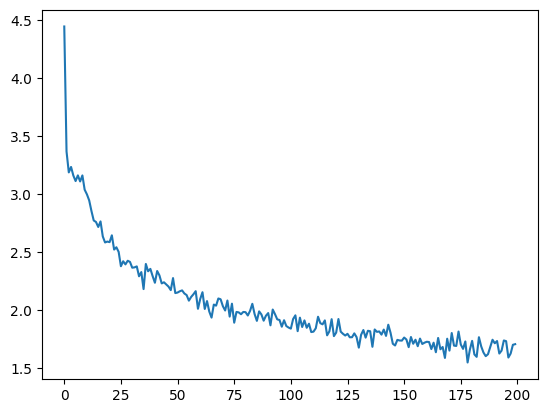

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)
